### 기본 Search Tool graph

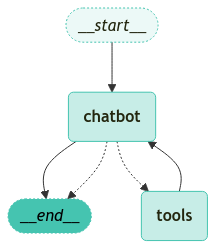

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_teddynote.tools.tavily import TavilySearch
from langchain_ollama import ChatOllama
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
tool = TavilySearch(max_results=3)
# 도구 목록 정의
tools = [tool]

# LLM 초기화
llm = ChatOllama(model="llama3.1:8b")
# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# 상태 그래프 생성
graph_builder = StateGraph(State)
# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=tools)
# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########
# tools > chatbot
graph_builder.add_edge("tools", "chatbot")
# START > chatbot
graph_builder.add_edge(START, "chatbot")
# chatbot > END
graph_builder.add_edge("chatbot", END)

########## 5. 그래프 컴파일 ##########
# 메모리 저장소 초기화
memory = MemorySaver()
# 그래프 빌더 컴파일
graph = graph_builder.compile(checkpointer=memory)

########## 6. 그래프 시각화 ##########
# 그래프 시각화
visualize_graph(graph)


### 1. 중간 단계의 상태(State) 수동 업데이트

##### 특정 단계 메세지 수정하기

In [2]:
from langchain_core.runnables import RunnableConfig

# 질문
question = "LangGraph 가 무엇인지 조사하여 알려주세요!"

# 초기 입력 상태를 정의
input = State(messages=[("user", question)])

# config 설정
config = RunnableConfig(
    configurable={"thread_id": "1"},  # 스레드 ID 설정
)

* 우선 채널목록을 출력하여 `interrupt_before` 와 `interrupt_after` 를 적용할 수 있는 목록을 출력합니다.

In [3]:
# 그래프 채널 목록 출력
list(graph.channels)

['messages',
 '__start__',
 'chatbot',
 'tools',
 'branch:__start__:__self__:chatbot',
 'branch:__start__:__self__:tools',
 'branch:chatbot:__self__:chatbot',
 'branch:chatbot:__self__:tools',
 'branch:tools:__self__:chatbot',
 'branch:tools:__self__:tools',
 'start:chatbot',
 'branch:chatbot:tools_condition:tools']

In [6]:
# 그래프 스트림 호출
events = graph.stream(
    input=input, config=config, interrupt_before=["tools"], stream_mode="values"
)

# 이벤트 반복 처리
for event in events:
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

================================ Human Message =================================

LangGraph 가 무엇인지 조사하여 알려주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (ce99c423-9851-4faf-b2d3-78ac86680856)
 Call ID: ce99c423-9851-4faf-b2d3-78ac86680856
  Args:
    query: LangGraph


In [7]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 가장 최근 메시지 추출
last_message = snapshot.values["messages"][-1]

# 메시지 출력
last_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (ce99c423-9851-4faf-b2d3-78ac86680856)
 Call ID: ce99c423-9851-4faf-b2d3-78ac86680856
  Args:
    query: LangGraph


In [8]:
modified_search_result = """[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요."""

print(modified_search_result)

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.


In [9]:
# 수정하고자 하는 `ToolMessage` 의 `tool_call_id` 추출
tool_call_id = last_message.tool_calls[0]["id"]
print(tool_call_id)

ce99c423-9851-4faf-b2d3-78ac86680856


In [10]:
from langchain_core.messages import AIMessage, ToolMessage

new_messages = [
    # LLM API의 도구 호출과 일치하는 ToolMessage 필요
    ToolMessage(
        content=modified_search_result,
        tool_call_id=tool_call_id,
    ),
    # LLM의 응답에 직접적으로 내용 추가
    # AIMessage(content=modified_search_result),
]

new_messages[-1].pretty_print()

================================= Tool Message =================================

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.


##### StateGraph의 update_state 메서드

In [11]:
graph.update_state(
    # 업데이트할 상태 지정
    config,
    # 제공할 업데이트된 값. `State`의 메시지는 "추가 전용"으로 기존 상태에 추가됨
    {"messages": new_messages},
    as_node="tools",
)

print("(최근 1개의 메시지 출력)\n")
print(graph.get_state(config).values["messages"][-1])

(최근 1개의 메시지 출력)

content='[수정된 웹 검색 결과] \nLangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.\nLangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.\n\n자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과\n테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.' id='c46889e7-f06f-4578-824c-91445825e487' tool_call_id='ce99c423-9851-4faf-b2d3-78ac86680856'


In [12]:
snapshot = graph.get_state(config)
snapshot.next

('chatbot',)

In [13]:
# `None`는 현재 상태에 아무것도 추가하지 않음
events = graph.stream(None, config, stream_mode="values")

# 이벤트 반복 처리
for event in events:
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.
================================== Ai Message ==================================

LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원하는 오픈 소스 라이브러리입니다. LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공합니다. 자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785)을 참고하세요.


In [18]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 최근 세 개의 메시지 출력
for message in snapshot.values["messages"]:
    message.pretty_print()


================================ Human Message =================================

LangGraph 가 무엇인지 조사하여 알려주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (62deb295-e65e-4946-b805-6010e4d2990a)
 Call ID: 62deb295-e65e-4946-b805-6010e4d2990a
  Args:
    query: LangGraph
================================= Tool Message =================================

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.
================================== Ai Message ==================================

LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원하는 오픈 소스 라이브러리입니다.
이러한 특징과 기능으로 인해 LangGraph는 다양한 사용자들이 이를 활용하여 스마트한 AI 모델을 개발하고 있습니다.


In [14]:
# 이 함수가 작동할 노드 지정. 이 노드가 방금 실행된 것처럼 자동으로 처리 계속
graph.update_state(
    config,
    {
        "messages": [
            AIMessage(content="마지막으로 최종 메시지를 추가하여 마무리 합니다.")
        ]
    },
    as_node="chatbot",
)


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe4519-3a0d-61a0-8007-5479fc7f482e'}}

In [15]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 최근 세 개의 메시지 출력
for message in snapshot.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

LangGraph 가 무엇인지 조사하여 알려주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (3b9978ff-40b8-4e7b-ae80-7f6a43de9890)
 Call ID: 3b9978ff-40b8-4e7b-ae80-7f6a43de9890
  Args:
    query: 대하 촜실각 장로면 아세
================================ Human Message =================================

LangGraph 가 무엇인지 조사하여 알려주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (ce99c423-9851-4faf-b2d3-78ac86680856)
 Call ID: ce99c423-9851-4faf-b2d3-78ac86680856
  Args:
    query: LangGraph
================================= Tool Message =================================

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
테디노트의 [랭체인 한국어 

In [16]:
# 다음 상태 출력
print(snapshot.next)

()


### 2. Interrupt 후 메시지 상태 업데이트 - 이어서 진행

In [17]:
from langchain_teddynote.graphs import generate_random_hash

thread_id = generate_random_hash()
print(f"thread_id: {thread_id}")

question = "LangGraph 에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!"

# 초기 입력 상태를 정의
input = State(messages=[("user", question)])

# 새로운 config 생성
config = {"configurable": {"thread_id": thread_id}}

events = graph.stream(
    input=input,
    config=config,
    interrupt_before=["tools"],
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

thread_id: 7e2085
================================ Human Message =================================

LangGraph 에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (bc1bd28a-f5f5-40c9-96a7-3c15cf017cf9)
 Call ID: bc1bd28a-f5f5-40c9-96a7-3c15cf017cf9
  Args:
    query: LangGraph


In [18]:
from langchain_core.messages import AIMessage

# 스냅샷 상태 가져오기
snapshot = graph.get_state(config)

# messages 의 마지막 메시지 가져오기
existing_message = snapshot.values["messages"][-1]

# 메시지 ID 출력
print("Message ID", existing_message.id)

Message ID run-b115de2f-3f50-48cf-8d97-e351967b25e4-0


In [19]:
# 첫 번째 도구 호출 출력
print(existing_message.tool_calls[0])

{'name': 'tavily_web_search', 'args': {'query': 'LangGraph'}, 'id': 'bc1bd28a-f5f5-40c9-96a7-3c15cf017cf9', 'type': 'tool_call'}


In [20]:
# tool_calls 를 복사하여 새로운 도구 호출 생성
new_tool_call = existing_message.tool_calls[0].copy()

# 쿼리 매개변수 업데이트(갱신)
new_tool_call["args"] = {"query": "LangGraph site:teddylee777.github.io"}
new_tool_call

{'name': 'tavily_web_search',
 'args': {'query': 'LangGraph site:teddylee777.github.io'},
 'id': 'bc1bd28a-f5f5-40c9-96a7-3c15cf017cf9',
 'type': 'tool_call'}

In [21]:
# AIMessage 생성
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # 중요! ID는 메시지를 상태에 추가하는 대신 교체하는 방법
    id=existing_message.id,
)

print(new_message.id)

# 수정한 메시지 출력
new_message.pretty_print()

run-b115de2f-3f50-48cf-8d97-e351967b25e4-0
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (bc1bd28a-f5f5-40c9-96a7-3c15cf017cf9)
 Call ID: bc1bd28a-f5f5-40c9-96a7-3c15cf017cf9
  Args:
    query: LangGraph site:teddylee777.github.io


In [22]:
# 업데이트된 도구 호출 출력
print(new_message.tool_calls[0])

# 메시지 ID 출력
print("\nMessage ID", new_message.id)

# 상태 업데이트
graph.update_state(config, {"messages": [new_message]})

{'name': 'tavily_web_search', 'args': {'query': 'LangGraph site:teddylee777.github.io'}, 'id': 'bc1bd28a-f5f5-40c9-96a7-3c15cf017cf9', 'type': 'tool_call'}

Message ID run-b115de2f-3f50-48cf-8d97-e351967b25e4-0


{'configurable': {'thread_id': '7e2085',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe45e1-87be-6b88-8002-c3521b7139e0'}}

In [23]:
# 마지막 메시지의 도구 호출 가져오기
graph.get_state(config).values["messages"][-1].tool_calls

[{'name': 'tavily_web_search',
  'args': {'query': 'LangGraph site:teddylee777.github.io'},
  'id': 'bc1bd28a-f5f5-40c9-96a7-3c15cf017cf9',
  'type': 'tool_call'}]

In [24]:
# 그래프 스트림에서 이벤트 수신
events = graph.stream(None, config, stream_mode="values")

# 각 이벤트에 대한 처리
for event in events:
    # 메시지가 있는 경우 마지막 메시지 출력
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (bc1bd28a-f5f5-40c9-96a7-3c15cf017cf9)
 Call ID: bc1bd28a-f5f5-40c9-96a7-3c15cf017cf9
  Args:
    query: LangGraph site:teddylee777.github.io
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "LangGraph - Multi-Agent Collaboration (다중 협업 ... - 테디노트", "url": "https://teddylee777.github.io/langgraph/langgraph-multi-agent-collaboration/", "content": "LangGraph - Multi-Agent Collaboration (다중 협업 에이전트) 로 복잡한 테스크를 수행하는 LLM 어플리케이션 제작 LangChain 에서 야심차게 LangGraph 를 새롭게 출시하였습니다.", "score": 0.40302688, "raw_content": "🔥알림🔥\n① 테디노트 유튜브 -\n구경하러 가기!\n② LangChain 한국어 튜토리얼\n바로가기 👀\n③ 랭체인 노트 무료 전자책(wikidocs)\n바로가기 🙌\n④ RAG 비법노트 LangChain 강의오픈\n바로가기 🙌\n⑤ 서울대 PyTorch 딥러닝 강의\n바로가기 🙌\nLangGraph - Multi-Agent Collaboration(다중 협업 에이전트) 로 복잡한 테스크를 수행하는 LLM 어플리케이션 제작\n2024년 01월 29일\n26 분 소요\nLangChain 에서 야심차게 LangGraph 를 새롭게 출시하였습니다.

In [25]:
# 이벤트 스트림 생성
events = graph.stream(
    {
        "messages": (
            "user",
            "내가 지금까지 배운 내용에 대해서 매우 친절하고 정성스럽게 한국어로 답변해줘! 출처를 반드시 포함해줘!",
        )
    },
    config,
    stream_mode="values",
)

# 메시지 이벤트 처리
for event in events:
    if "messages" in event:
        # 마지막 메시지 출력
        event["messages"][-1].pretty_print()

================================ Human Message =================================

내가 지금까지 배운 내용에 대해서 매우 친절하고 정성스럽게 한국어로 답변해줘! 출처를 반드시 포함해줘!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (2f3b2679-16e2-4522-8fec-98dd4749417b)
 Call ID: 2f3b2679-16e2-4522-8fec-98dd4749417b
  Args:
    query: 자바스크립트와 React를 이용한 front-end 개발에 대한 내용
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "자바스크립트와 React.js를 활용한 프론트엔드 개발 가이드", "url": "https://colinch4.github.io/2023-11-09/08-30-45-562575-자바스크립트와-reactjs를-활용한-프론트엔드-개발-가이드/", "content": "프론트엔드 개발을 위해 자바스크립트와 React.js를 활용하기 위해서는 기본적인 자바스크립트 문법과 DOM 조작에 대한 이해가 필요합니다. 또한 React.js의 기본 개념과 컴포넌트의 동작 원리에 대한 학습이 필요합니다. 4. 추가 자료 및 참고 사이트. React 공식", "score": 0.918838, "raw_content": "목차\n1. 자바스크립트란\n자바스크립트(JavaScript)는 웹 개발에서 가장 널리 사용되는 프로그래밍 언어 중 하나입니다. 웹 페이지 상에서 동적인 기능을 구현할 수 있게 해주며, 클라이언트 측 프론트엔드 개발에 주로 사용됩니다. 자바스크립트는 객체 지향적

### Replay

In [26]:
to_replay_state = None

# 상태 기록 가져오기
for state in graph.get_state_history(config):

    messages = state.values["messages"]

    if len(messages) > 0:
        print(state.values["messages"][-1].id)
        # 메시지 수 및 다음 상태 출력
        print("메시지 수: ", len(state.values["messages"]), "다음 노드: ", state.next)
        print("-" * 80)
        # 특정 상태 선택 기준: 채팅 메시지 수
        if len(state.values["messages"]) == 2:
            # 특정 메시지 ID 선택
            to_replay_state = state

run-4305ab26-daaa-4d4d-bcfc-f6056bf3fc2e-0
메시지 수:  8 다음 노드:  ()
--------------------------------------------------------------------------------
b697d8b9-9935-441e-94e3-457316bed243
메시지 수:  7 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
run-d293b5ea-3117-4149-8f14-d63ba146fc68-0
메시지 수:  6 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
eb8e4107-43e5-4897-aef3-08aaf6916bdd
메시지 수:  5 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
run-d9028027-28ef-42c9-9671-fd55854d29b0-0
메시지 수:  4 다음 노드:  ('__start__',)
--------------------------------------------------------------------------------
run-d9028027-28ef-42c9-9671-fd55854d29b0-0
메시지 수:  4 다음 노드:  ()
--------------------------------------------------------------------------------
2ef656c7-4620-42ee-8985-ce79f5e863d3
메시지 수:  3 다음 노드:  ('chatbot',)
----------------------------------

In [27]:
from langchain_teddynote.messages import display_message_tree

# 선택한 메시지 가져오기
existing_message = to_replay_state.values["messages"][-1]

# 메시지 트리 출력
display_message_tree(existing_message)


    content: ""
    additional_kwargs: {}
    response_metadata:
        model: "llama3.1:8b"
        created_at: "2025-02-06T07:42:22.99835Z"
        done: True
        done_reason: "stop"
        total_duration: 7914554000
        load_duration: 824460542
        prompt_eval_count: 221
        prompt_eval_duration: 5024000000
        eval_count: 21
        eval_duration: 2063000000
        message: {"role": "assistant", "content": "", "images": None, "tool_calls": None}
    type: "ai"
    name: None
    id: "run-b115de2f-3f50-48cf-8d97-e351967b25e4-0"
    example: False
    tool_calls:
        index [0]
            name: "tavily_web_search"
            args: {"query": "LangGraph"}
            id: "bc1bd28a-f5f5-40c9-96a7-3c15cf017cf9"
            type: "tool_call"
    invalid_tool_calls:
    usage_metadata: {"input_tokens": 221, "output_tokens": 21, "total_tokens": 242}


In [28]:
tool_call = existing_message.tool_calls[0].copy()
tool_call["args"] = {"query": "LangGraph human-in-the-loop workflow site:reddit.com"}
tool_call

{'name': 'tavily_web_search',
 'args': {'query': 'LangGraph human-in-the-loop workflow site:reddit.com'},
 'id': 'bc1bd28a-f5f5-40c9-96a7-3c15cf017cf9',
 'type': 'tool_call'}

In [29]:
# AIMessage 생성
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[tool_call],
    # 중요! ID는 메시지를 상태에 추가하는 대신 교체하는 방법
    id=existing_message.id,
)

# 수정한 메시지 출력
new_message.tool_calls[0]["args"]

{'query': 'LangGraph human-in-the-loop workflow site:reddit.com'}

In [30]:
# 수정 전 메시지 확인
graph.get_state(to_replay_state.config).values["messages"][-1].tool_calls


[{'name': 'tavily_web_search',
  'args': {'query': 'LangGraph'},
  'id': 'bc1bd28a-f5f5-40c9-96a7-3c15cf017cf9',
  'type': 'tool_call'}]

In [31]:
# 상태 업데이트
updated_state = graph.update_state(
    to_replay_state.config,
    {"messages": [new_message]},
)
updated_state

{'configurable': {'thread_id': '7e2085',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe4634-3723-664e-8002-8decd32e611b'}}

In [32]:
# config 에는 updated_state 를 전달합니다. 이는 임의로 갱신한 상태를 전달하는 것입니다.
for event in graph.stream(None, updated_state, stream_mode="values"):
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지 출력
        event["messages"][-1].pretty_print()


================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (bc1bd28a-f5f5-40c9-96a7-3c15cf017cf9)
 Call ID: bc1bd28a-f5f5-40c9-96a7-3c15cf017cf9
  Args:
    query: LangGraph human-in-the-loop workflow site:reddit.com
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "Human intervention in agent workflows : r/LangChain - Reddit", "url": "https://www.reddit.com/r/LangChain/comments/1bjnmu4/human_intervention_in_agent_workflows/", "content": "When building LLM workflows with LangChain/LangGraph what's the best way to build a node in the workflow where a human can validate/approve/reject a flow? I know there is a Human-in-the-loop component in LangGraph that will prompt the user for input. But what if I'm not creating a user-initiated chat conversation, but a flow that reacts to e.g", "score": 0.7067782, "raw_content": null}, {"title": "LangGraph Workflow for Quality Ass

In [33]:
# 최종 결과 출력
for msg in graph.get_state(config).values["messages"]:
    msg.pretty_print()

================================ Human Message =================================

LangGraph 에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (bc1bd28a-f5f5-40c9-96a7-3c15cf017cf9)
 Call ID: bc1bd28a-f5f5-40c9-96a7-3c15cf017cf9
  Args:
    query: LangGraph human-in-the-loop workflow site:reddit.com
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "Human intervention in agent workflows : r/LangChain - Reddit", "url": "https://www.reddit.com/r/LangChain/comments/1bjnmu4/human_intervention_in_agent_workflows/", "content": "When building LLM workflows with LangChain/LangGraph what's the best way to build a node in the workflow where a human can validate/approve/reject a flow? I know there is a Human-in-the-loop component in LangGraph that will prompt the user for input. But what if I'm not creating a user-initiated chat convers

In [67]:
for state in graph.get_state_history(config):
    print(state.next)
    print(state.config['configurable']['checkpoint_id'])

()
1efe4637-2c07-65d2-8004-a282462286bb
('chatbot',)
1efe4635-5726-64f4-8003-26bed745ef29
('tools',)
1efe4634-3723-664e-8002-8decd32e611b
()
1efe45ef-4e26-6b06-8009-85efe20366e0
('chatbot',)
1efe45eb-e131-615c-8008-0b640ef8f6d2
('tools',)
1efe45eb-b050-6e20-8007-013cc3a9670c
('chatbot',)
1efe45eb-55fc-6500-8006-3bf43463287a
('__start__',)
1efe45eb-55e7-6d6c-8005-3c70880ce385
()
1efe45e4-f45e-6e8e-8004-1834c023e49b
('chatbot',)
1efe45e3-2e45-6faa-8003-8493dc7fc6ea
('tools',)
1efe45e1-87be-6b88-8002-c3521b7139e0
('tools',)
1efe45de-6fbc-6bd2-8001-79db95f6cf33
('chatbot',)
1efe45de-23ee-6228-8000-92b9ebbe102c
('__start__',)
1efe45de-23d7-6ae6-bfff-b55f73170651
